In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Carrega a tabela imortação
imp_fert=pd.read_csv('~/git/BD/temp/imp_fert_ncm_cat.csv').reset_index(drop=True)
imp_fert.shape

(89785, 11)

### Identifica as colunas quantitativas

In [2]:
col_quanti=[x for x in imp_fert.columns if x[:2]=='VL' or x[:2]=='KG']
col_quanti

['KG_LIQUIDO', 'VL_FOB', 'VL_FRETE', 'VL_SEGURO']

### Avalia impacto e elimina registros com quantidade igual a zero

In [3]:
# Avalia impacto na eliminação de registros com quantidade zero
for q in col_quanti:
    print(f"{q} possui {round(100*imp_fert[imp_fert[q]==0].shape[0]/imp_fert.shape[0],1)} % dos registros com valor igual a zero.")

KG_LIQUIDO possui 0.0 % dos registros com valor igual a zero.
VL_FOB possui 0.0 % dos registros com valor igual a zero.
VL_FRETE possui 0.3 % dos registros com valor igual a zero.
VL_SEGURO possui 21.9 % dos registros com valor igual a zero.


In [4]:
for q in col_quanti:
    par=imp_fert[imp_fert[q]==0][[x for x in col_quanti if x not in [q]]].sum()
    tot=imp_fert[imp_fert[q]!=0][[x for x in col_quanti if x not in [q]]].sum()
    print('Qdo ',q,'= 0:')
    print(f"{100*(par/tot)} % do total.")
    print()

Qdo  KG_LIQUIDO = 0:
VL_FOB       2.237782e-06
VL_FRETE     6.689952e-09
VL_SEGURO    0.000000e+00
dtype: float64 % do total.

Qdo  VL_FOB = 0:
KG_LIQUIDO    0.0
VL_FRETE      0.0
VL_SEGURO     0.0
dtype: float64 % do total.

Qdo  VL_FRETE = 0:
KG_LIQUIDO    0.000108
VL_FOB        0.000101
VL_SEGURO     0.000002
dtype: float64 % do total.

Qdo  VL_SEGURO = 0:
KG_LIQUIDO    6.538281
VL_FOB        6.165241
VL_FRETE      6.187750
dtype: float64 % do total.



In [5]:
# Seleciona colunas para descate de zero
col_quanti=[x for x in col_quanti if x not in ['VL_SEGURO']]
col_quanti

['KG_LIQUIDO', 'VL_FOB', 'VL_FRETE']

In [6]:
# Descarta registros com valor igual a zero
for c in col_quanti:
    imp_fert=imp_fert[imp_fert[c]>0]

### Corrige inflação monetária

In [7]:
# Carrega função de correção do dólar
%run '/home/andre301267/git/BD/Comexstat/function/corrige_inflação_dólar.ipynb'


Função ***corrige_inflação_dólar(df_ano_mes_valor,col_vl_name)*** disponível.



In [8]:
# Identifica valores a serem corrigidos da inflação
col_val=[x for x in imp_fert.columns if x[:2]=='VL']
col_val

['VL_FOB', 'VL_FRETE', 'VL_SEGURO']

In [9]:
# Salva backup e corrige inflação
for cv in col_val:
    imp_fert.insert(7,cv+'_orig',imp_fert[cv])
    imp_fert=corrige_inflação_dólar(imp_fert,cv)

In [10]:
imp_fert.columns

Index(['CO_ANO', 'CO_MES', 'CO_NCM', 'nick', 'UF', 'CO_PAIS', 'CO_URF',
       'VL_SEGURO_orig', 'VL_FRETE_orig', 'VL_FOB_orig', 'KG_LIQUIDO',
       'VL_FOB', 'VL_FRETE', 'VL_SEGURO'],
      dtype='object')

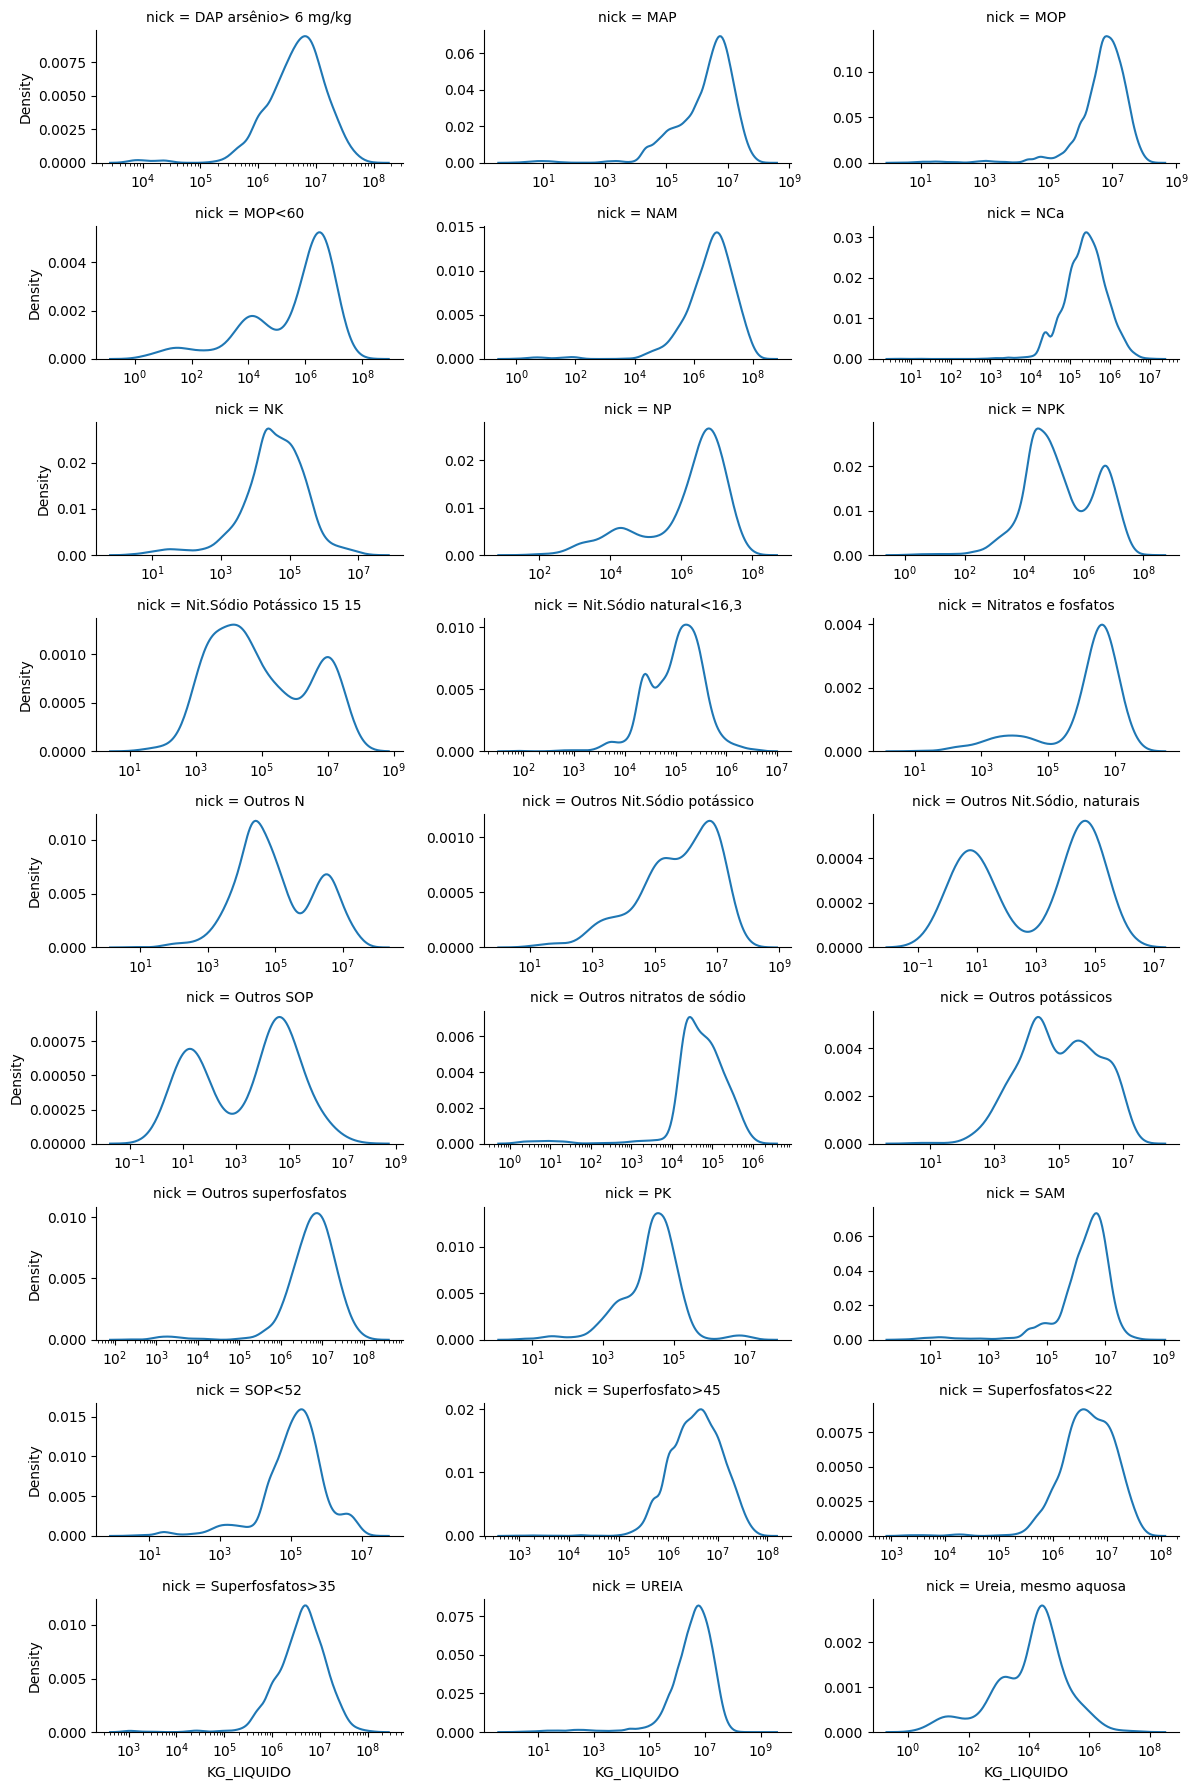

In [11]:
sns.displot(kind='kde',data=imp_fert.sort_values('nick'),x='KG_LIQUIDO',col='nick',col_wrap=3,height=2,aspect=2,\
            log_scale=True,facet_kws=dict(sharey=False,sharex=False))

## Clusteriza NCM

In [12]:
imp_fert['log_kg']=np.log10(imp_fert.KG_LIQUIDO)
imp_fert['log_fob']=np.log10(imp_fert.VL_FOB)
imp_fert['log_frete']=np.log10(imp_fert.VL_FRETE)
imp_fert['cif_kg']=(imp_fert.VL_FOB+imp_fert.VL_FRETE)/imp_fert.KG_LIQUIDO
imp_fert['fob_kg']=(imp_fert.VL_FOB)/imp_fert.KG_LIQUIDO

In [13]:
%run '/home/andre301267/git/BD/Comexstat/function/clusteriza_ncm.ipynb'

** Função clusteriza_ncm(imp_fert, n_clusters=4, cols_base=['s_log_kg','s_log_fob']) disponível **


In [14]:
n_cluster_list=[1,2,3,
                3,2,1,
                6,2,2,
                5,3,2,
                2,3,2,
                2,2,4,
                1,3,2,
                5,1,1,
                1,2,4]
ncm_list=imp_fert['nick'].drop_duplicates().sort_values().values
d=dict(zip(ncm_list,n_cluster_list))

In [15]:
q=pd.DataFrame()
for n in ncm_list:
    t=imp_fert[imp_fert.nick==n]
    t=clusteriza_ncm(t,n_clusters=d[n],cols_base=['log_kg','log_fob','log_frete','cif_kg','fob_kg'])
    q=pd.concat([q,t])

In [16]:
imp_fert=q

In [17]:
imp_fert[(imp_fert.nick=='MAP')&(imp_fert.km==1)].KG_LIQUIDO.min()

np.int64(330000)

In [ ]:
sns.displot(data=imp_fert,x='KG_LIQUIDO',col='nick', hue='km',col_wrap=3,height=2,aspect=2,\
            log_scale=True,facet_kws=dict(sharey=False))

### Corrige oputliers através do preço

Confere maior registro de peso:

In [ ]:
imp_fert[imp_fert.KG_LIQUIDO==imp_fert.KG_LIQUIDO.max()]

Confere a soma geral

In [ ]:
imp_fert[['KG_LIQUIDO','VL_FOB']].sum()/10**9

Carrega função para correção via preço

In [ ]:
%run '/home/andre301267/git/BD/Comexstat/function/corr_kg_fob_via_preço.ipynb'

Corrige

In [ ]:
q=pd.DataFrame()
z=3
k=0
f=0
for ncm in imp_fert.CO_NCM.unique():
    for km in imp_fert.km.unique():
        t=imp_fert[(imp_fert.CO_NCM==ncm)&(imp_fert.km==km)]
        t, len_err_kg, len_err_fob=corr_kg_fob_via_preço(t,z)
        q=pd.concat([q,t])
        k+=len_err_kg
        f+=len_err_fob

print(f"Através do preço, foram corrigidos {k} registros de kg e {f} registros de valor fob, que estavam a mais de {z} vezes \
o desvio padrão\nde distância da média (z score).")

imp_fert=q.copy()

Confere maior registro de peso:

In [ ]:
imp_fert[imp_fert.KG_LIQUIDO==imp_fert.KG_LIQUIDO.max()]

Confere a soma geral

In [ ]:
imp_fert[['KG_LIQUIDO','VL_FOB']].sum()/10**9

In [ ]:
imp_fert=imp_fert[[
    'CO_ANO', 'CO_MES', 'CO_NCM', 'nick', 'UF', 'CO_PAIS', 'CO_URF',
    'VL_SEGURO_orig', 'VL_FRETE_orig', 'VL_FOB_orig', 'KG_LIQUIDO',
    'VL_FOB', 'VL_FRETE', 'VL_SEGURO', 'km']]

In [ ]:
imp_fert.to_csv('/home/andre301267/git/BD/temp/imp_fert_ncm_quanti.csv',index=False)